In [1]:
import pyodbc
import pandas as pd
import numpy as np
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

import chart_studio.plotly as py

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Criando a conexao
dbConexao = ("Driver={SQL Server};"
             "Server=LAPTOP-9ESLAMPG;"
             "Database=AdventureWorksDW2019;"
)

In [3]:
# Efetuando a conexão
conexao = pyodbc.connect(dbConexao)
print('Conexao Feita')

Conexao Feita


In [4]:
# Pegando os dados e salvando em uma variável
dfVendas = pd.read_sql_query('SELECT * FROM vwVendasProdutoCategoria', conexao)

## COMENTÁRIOS:

### COMO A QUERY DIGITADA DENTRO DO BANCO DE DADOS É MUITO GRANDE, CRIEI UMA VIEW

### O COMANDO SQL USADO NA VIEW FOI:

    SELECT 
        D.CalendarYear                                            AS "ANO",
        P.EnglishProductName                                      AS "PRODUTO",
        C.EnglishProductCategoryName                              AS "CATEGORIA",
        T.SalesTerritoryCountry                                   AS "PAIS",
        T.SalesTerritoryGroup                                     AS "REGIAO",
        SUM(V.SalesAmount)                                        AS "VENDAS"
    FROM FactInternetSales                                        AS V
    LEFT JOIN dbo.DimProduct                                      AS P
        ON V.ProductKey = P.ProductKey
    LEFT JOIN dbo.DimProductSubcategory                           AS S
        ON P.ProductSubcategoryKey = S.ProductSubcategoryKey
    LEFT JOIN dbo.DimProductCategory                              AS C
        ON S.ProductCategoryKey = C.ProductCategoryKey
    LEFT JOIN dbo.DimSalesTerritory                               AS T
        ON V.SalesTerritoryKey = T.SalesTerritoryKey
    LEFT JOIN dbo.DimDate                                         AS D
        ON V.OrderDateKey = D.DateKey
    WHERE V.CurrencyKey = 100
    GROUP BY D.CalendarYear,
        P.EnglishProductName,
        T.SalesTerritoryGroup,
        T.SalesTerritoryCountry,
        C.EnglishProductCategoryName
         
 
### O FILTRO WHERE V.CurrencyKey = 100, vai trazer somente as vendas em USD

In [5]:
# Verificando os dados
dfVendas.head()

,ANO,PRODUTO,CATEGORIA,PAIS,REGIAO,VENDAS
0,2014,ML Road Tire,Accessories,United States,North America,249.90
1,2013,Bike Wash - Dissolver,Accessories,United States,North America,2647.35
2,2013,"Touring-2000 Blue, 50",Bikes,France,Europe,9718.80
3,2013,"Touring-2000 Blue, 46",Bikes,Germany,Europe,12148.50
4,2014,"Half-Finger Gloves, M",Clothing,France,Europe,48.98


In [6]:
print(dfVendas.shape)

print(dfVendas.info())

(824, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ANO        824 non-null    int64  
 1   PRODUTO    824 non-null    object 
 2   CATEGORIA  824 non-null    object 
 3   PAIS       824 non-null    object 
 4   REGIAO     824 non-null    object 
 5   VENDAS     824 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 38.8+ KB
None


### CONHECENDO OS NOSSOS DADOS: 

### O nosso dataset possui um total de 6 colunas:

1. ANO -> int64, periodo do qual a venda foi realizada;
1. PRODUTO -> object, nome do produto vendido;
1. CATEGORIA -> object, categoria da qual o produto faz parte;
1. PAIS -> object, pais onde a venda foi efetivada
1. REGIAO -> object, regiao do pais, onde a venda foi efetivada;
1. VENDAS -> float64, vendas realizadas

In [7]:
# Analisando o dataset

# 1.Verificando se o dataset tem valores vazios
dfVendas.isnull().sum()

ANO          0
PRODUTO      0
CATEGORIA    0
PAIS         0
REGIAO       0
VENDAS       0
dtype: int64

In [8]:
# Verificando algumas métricas
dfVendas['VENDAS'].describe()

count       824.000000
mean      17831.875387
std       49794.386422
min           2.290000
25%         126.715000
50%        2051.032300
75%       11945.325000
max      475909.910000
Name: VENDAS, dtype: float64

In [9]:
dfVendas['VENDAS'].mode()

0       8.9900
1    1398.1964
Name: VENDAS, dtype: float64

In [10]:
dfVendas['VENDAS'].var()

2479480919.1535454

### COMENTÁRIOS SOBRE AS MÉTRICAS:

1. **DESVIO PADRÃO:** Esse valor em nosso dataset é extramente grande, mostra que temos dados muitos distantes da media;
1. **VARIANCIA:** Esse valor é extramente grande se comparado a média dos dados, podemos concluir que os dados estão muitos distantes entre si..
1. **MODA VS. MEDIANA:** Aqui temos a mediana dos dados (50%) maior que a moda;
1. **MEDIANA VS. MÉDIA:** Aqui temos uma mediana menor que a média
    *Conlusão:* Os nossos dados são do tipo de uma distribuição assimétrica à direita, ou de assimetria positiva -> Moda < Mediana < Média

Text(0.5, 0.98, 'DISTRIBUIÇÃO DE VENDAS')

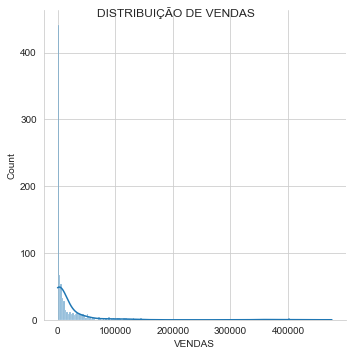

In [11]:
# Verificando em gráfico a conclusão do COMENTÁRIO 4

graf = sns.displot(data=dfVendas, x=dfVendas['VENDAS'], kde=True)
graf.fig.suptitle("DISTRIBUIÇÃO DE VENDAS")

### COMENTÁRIOS SOBRE O GRAFICO 1 (DISTRIBUIÇÃO DE VENDAS):

5. **CONFIRMAÇÃO DO TIPO DA DISTRIBUIÇÃO:** No comentário 4 (Mediana vs Média), já sabiamos que o nosso gráfico teria o formato de "Elevação" a direita do gráfico
6. **DESCREPANCIA DE DADOS:** Temos valore descrepantes em nossos dados, esse tipo de comportamento já era esperando devido ao valor do desvio padrão

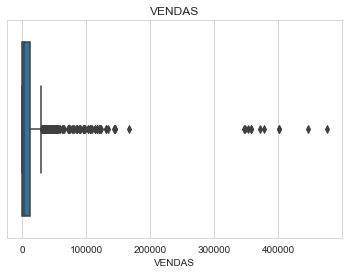

In [12]:
# Visualizando os dados em um Boxplot, pois acho mais fácil (nesse exercício) visualmente identificar os outliers

boxplot = sns.boxplot(x = dfVendas['VENDAS'], data=dfVendas)

plt.title("VENDAS")
plt.show()

In [13]:
# verificando as categorias de vendas

dfVendas_Categoria = dfVendas.groupby('CATEGORIA', as_index=False)['VENDAS'].mean()

dfVendas_Categoria

,CATEGORIA,VENDAS
0,Accessories,1491.624586
1,Bikes,37315.855340
2,Clothing,1062.777000


### TRATAMENTO DOS OUTLIERS:

7. Como em nosso dataset temos categorias de produtos, iremos tratar os outliers separadamente de cada categoria;
8. Farei um filtro para pegar as 100 maiores vendas de cada categoria;
9. Irei criar uma função para remover os outliers dessas 100 maiores vendas de cada categoria;

### COMENTÁRIOS:

10. Irei escolher as 100 maiores vendas de cada categoria, pois analisando as métricas, vermos que 75% dos dados possuem "vendas grandes" e se efetuarmos a exclusão desses dados, perderemos informações importantes;
11. O filtro será feito separadamente por categoria, pois se fizermos o filtro sem separar as categorias, possivelmente iremos pegar as vendas somente de uma categoria ou até mesmo somente de duas

In [14]:
# Separando as categorias

mask_Accessories = dfVendas['CATEGORIA'] == 'Accessories'
mark_Bikes = dfVendas['CATEGORIA'] == 'Bikes'
mark_Clothing = dfVendas['CATEGORIA'] == 'Clothing'

dfVendas_Accessories = dfVendas[mask_Accessories]
dfVendas_Clothing = dfVendas[mark_Bikes]
dfVendas_Bikes = dfVendas[mark_Clothing]

In [15]:
# Pegando as 100 maiores vendas de cada categoria

dfVendas_top100_Accessories = dfVendas_Accessories.nlargest(100, 'VENDAS')
dfVendas_top100_Bikes = dfVendas_Clothing.nlargest(100, 'VENDAS')
dfVendas_top100_Clothing = dfVendas_Bikes.nlargest(100, 'VENDAS')

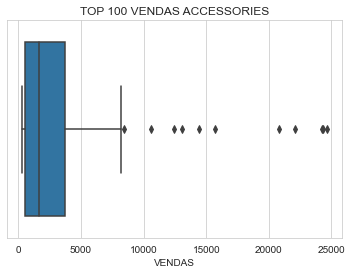

In [16]:
boxplot = sns.boxplot(x=dfVendas_top100_Accessories['VENDAS'], data=dfVendas_top100_Accessories)

plt.title("TOP 100 VENDAS ACCESSORIES")
plt.show()

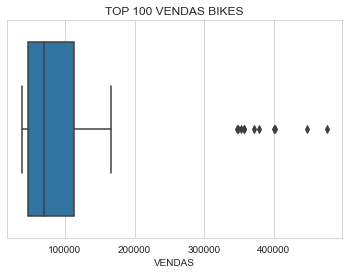

In [17]:
boxplot = sns.boxplot(x=dfVendas_top100_Bikes['VENDAS'], data=dfVendas_top100_Accessories)

plt.title("TOP 100 VENDAS BIKES")
plt.show()

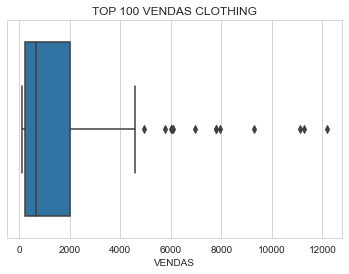

In [18]:
boxplot = sns.boxplot(x=dfVendas_top100_Clothing['VENDAS'], data=dfVendas_top100_Accessories)

plt.title("TOP 100 VENDAS CLOTHING")
plt.show()

### VERIFCANDO OS 3 GRÁFICOS, CONCLUÍMOS:

1. **GRÁFICO TOP 100 VENDAS ACCESSORIES** -> Pode-se ver claramente que os valores acima de 10.000 estão agindo como os outliers;
1. **GRÁFICO TOP 100 VENDAS BIKES** -> Pode-se ver claramente que os valores acima de 300.000 estão agindo como os outliers;
1. **GRAFICO TOP 100 VENDAS CLOTHING** -> Pode-se ver claramente que os valores acima de 6.000 estão agindo como os outliers;

Nesse caso, irei contar 'quantos outliers' existem dentro de cada categoria levando em consideração o terceiro quartil

In [19]:
# Pegandos os quartis da categoria Accessories
q3, q1 = np.percentile(dfVendas_top100_Accessories['VENDAS'], (75,25))

print(q1)
print(q3)

553.125
3685.6675


In [20]:
# Contando "quantos dados" estão acima do 3º quartil da categoria Accessories
dfContador_Accessories = dfVendas_top100_Accessories['VENDAS'] > 3685.6675

dfVendas_OutliersAccessories = dfVendas_top100_Accessories[dfContador_Accessories]

dfVendas_OutliersAccessories['VENDAS'].count()

25

In [21]:
# Pegandos os quartis da categoria Bikes
q3, q1 = np.percentile(dfVendas_top100_Bikes['VENDAS'], (75,25))

print(q1)
print(q3)

47573.515
113751.215


In [22]:
# Contando "quantos dados" estão acima do 3º quartil da categoria Bikes
dfContador_Bikes = dfVendas_top100_Bikes['VENDAS'] > 113751.215

dfVendas_OutliersBikes = dfVendas_top100_Bikes[dfContador_Bikes]

dfVendas_OutliersBikes['VENDAS'].count()

25

In [23]:
# Pegandos os quartis da categoria Clothing
q3, q1 = np.percentile(dfVendas_top100_Clothing['VENDAS'], (75,25))

print(q1)
print(q3)

215.96
2000.8925


In [24]:
# Contando "quantos dados" estão acima do 3º quartil da categoria Clothing
dfContador_Clothing = dfVendas_top100_Clothing['VENDAS'] > 2000.8925

dfVendas_OutliersClothing = dfVendas_top100_Clothing[dfContador_Clothing]

dfVendas_OutliersClothing['VENDAS'].count()

25

### Analisando os contadores de outliers vemos que essa quantidade de dados é pequena se comparada a quantidade total de cada categoria, então irei apagar esses outliers

In [25]:
# pegando os indices dos outliers de cada categoria

indice_Accessories = dfVendas_top100_Accessories[dfVendas_top100_Accessories.VENDAS > 3685.6675].index

indice_Bikes = dfVendas_top100_Bikes[dfVendas_top100_Bikes.VENDAS > 113751.215].index

indice_Clothing = dfVendas_top100_Clothing[dfVendas_top100_Clothing.VENDAS > 2000.8925].index

In [26]:
# apagando os outliers

dfVendas_CleanAccessories = dfVendas_top100_Accessories.drop(indice_Accessories, inplace = False)
dfVendas_CleanBikes = dfVendas_top100_Bikes.drop(indice_Bikes, inplace = False)
dfVendas_CleanClothing  = dfVendas_top100_Clothing.drop(indice_Clothing, inplace = False)

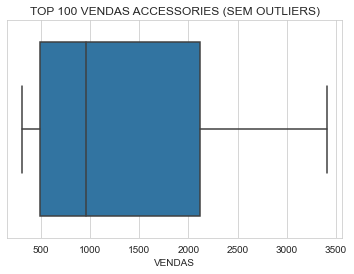

In [27]:
boxplot = sns.boxplot(x=dfVendas_CleanAccessories['VENDAS'], data=dfVendas_CleanAccessories)

plt.title("TOP 100 VENDAS ACCESSORIES (SEM OUTLIERS)")
plt.show()

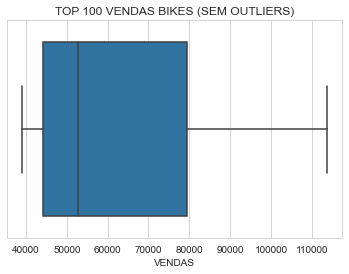

In [28]:
boxplot = sns.boxplot(x=dfVendas_CleanBikes['VENDAS'], data=dfVendas_CleanBikes)

plt.title("TOP 100 VENDAS BIKES (SEM OUTLIERS)")
plt.show()

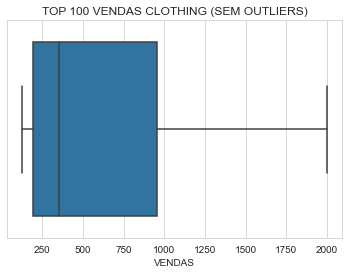

In [29]:
boxplot = sns.boxplot(x=dfVendas_CleanClothing['VENDAS'], data=dfVendas_CleanClothing)

plt.title("TOP 100 VENDAS CLOTHING (SEM OUTLIERS)")
plt.show()

In [30]:
# Unindo os dados limpos em um unico data frame
dfVendas_Clean = pd.concat([dfVendas_CleanAccessories, dfVendas_CleanBikes, dfVendas_CleanClothing],
                                  ignore_index=False)

dfVendas_Clean.head()

,ANO,PRODUTO,CATEGORIA,PAIS,REGIAO,VENDAS
262,2013,Fender Set - Mountain,Accessories,Germany,Europe,3406.90
200,2013,Touring Tire,Accessories,Germany,Europe,3304.86
624,2013,All-Purpose Bike Stand,Accessories,Germany,Europe,3180.00
242,2013,LL Road Tire,Accessories,Germany,Europe,3094.56
378,2013,Hitch Rack - 4-Bike,Accessories,France,Europe,2880.00


# CALCULANDO MÉDIAS

In [31]:
# 1. Qual ano possui a maior média de vendas ?

dfVendas_ano = dfVendas_Clean.groupby('ANO', as_index=False)['VENDAS'].mean()

dfVendas_ano

# R-> 2012

,ANO,VENDAS
0,2011,45964.921000
1,2012,61375.703216
2,2013,24546.517826
3,2014,411.144000


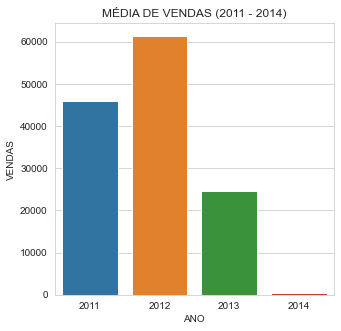

In [32]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 1 EM UM GRAFICO

#ax = sns.barplot(x="tip", y="day", data=tips)
#ax = sns.set(xlabel='common xlabel', ylabel='common ylabel')

plt.figure(figsize=(5,5))
fig = sns.barplot(x=dfVendas_ano['ANO'], y=dfVendas_ano['VENDAS'], data=dfVendas_ano)
plt.title('MÉDIA DE VENDAS (2011 - 2014)')
#plt.xticks(rotation=90)
plt.show(fig)

In [33]:
# 2. Qual categoria possui a maior média de vendas ?

dfVendas_cat = dfVendas_Clean.groupby('CATEGORIA', as_index=False)['VENDAS'].mean()

dfVendas_cat

# R-> Bikes

,CATEGORIA,VENDAS
0,Accessories,1314.372800
1,Bikes,62713.266405
2,Clothing,608.722667


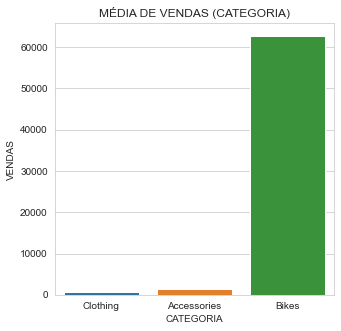

In [34]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 2 EM UM GRAFICO

#ax = sns.barplot(x="tip", y="day", data=tips)
#ax = sns.set(xlabel='common xlabel', ylabel='common ylabel')

plt.figure(figsize=(5,5))
fig = sns.barplot(x=dfVendas_cat['CATEGORIA'], y=dfVendas_cat['VENDAS'], data=dfVendas_cat,
                  order=dfVendas_cat.sort_values('VENDAS').CATEGORIA)

plt.title('MÉDIA DE VENDAS (CATEGORIA)')
#plt.xticks(rotation=90)
plt.show(fig)

In [35]:
# 3. Qual pais possui a maior média de vendas ?

dfVendas_pais = dfVendas_Clean.groupby('PAIS', as_index=False)['VENDAS'].mean()

dfVendas_pais

# R-> United States

,PAIS,VENDAS
0,Australia,331.842353
1,Canada,2221.326667
2,France,23790.203540
3,Germany,21415.652660
4,United Kingdom,181.720000
5,United States,32302.376828


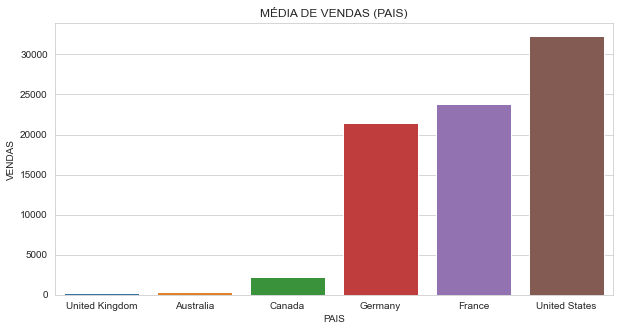

In [36]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 3 EM UM GRAFICO

#ax = sns.barplot(x="tip", y="day", data=tips)
#ax = sns.set(xlabel='common xlabel', ylabel='common ylabel')

plt.figure(figsize=(10,5))
fig = sns.barplot(x=dfVendas_pais['PAIS'], y=dfVendas_pais['VENDAS'], data=dfVendas_pais,
                  order=dfVendas_pais.sort_values('VENDAS').PAIS)

plt.title('MÉDIA DE VENDAS (PAIS)')
#plt.xticks(rotation=90)
plt.show(fig)

In [37]:
# 4. Qual produto possui a maior média de vendas ? (média do acumulado de todos os anos do dataset)

dfVendas_prod = dfVendas_Clean.groupby('PRODUTO', as_index=False)['VENDAS'].mean()

dfVendas_prod.sort_values(by='VENDAS', ascending=False)

# R-> Mountain-200 Silver, 46 e Mountain-200 Silver, 38 possuem as maiores médias de vendas

,PRODUTO,VENDAS
32,"Mountain-200 Silver, 46",102079.560000
27,"Mountain-200 Black, 38",99422.245133
31,"Mountain-200 Silver, 42",97771.006400
30,"Mountain-200 Silver, 38",86833.910700
58,"Road-550-W Yellow, 42",85157.240000
...,...,...
4,"Classic Vest, M",455.083333
10,"Half-Finger Gloves, M",410.207500
0,AWC Logo Cap,296.670000
16,"Long-Sleeve Logo Jersey, L",266.613333


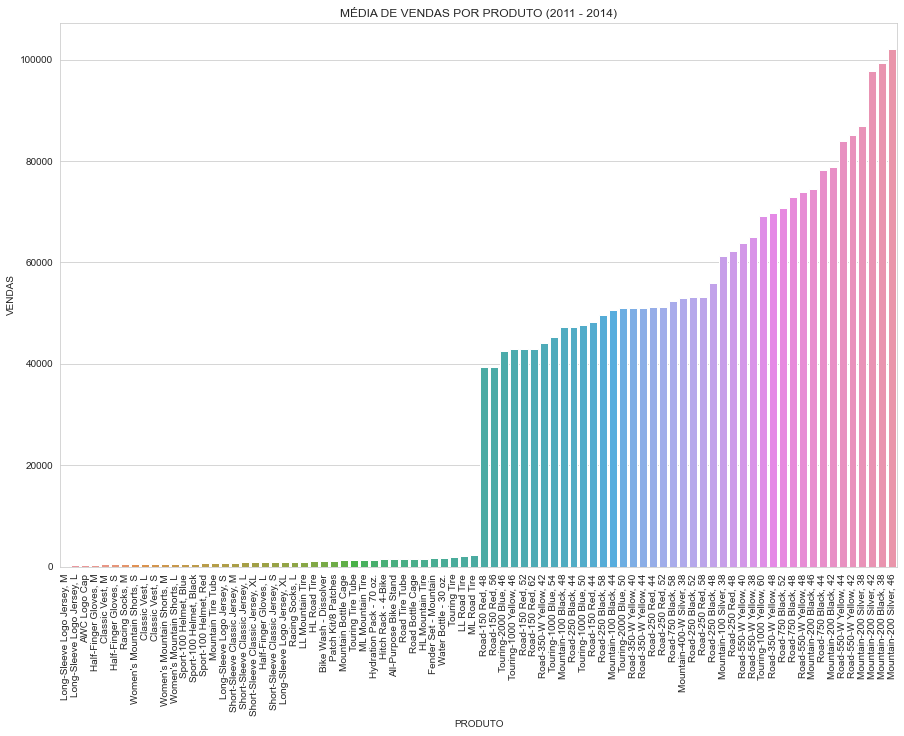

In [38]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 4 EM UM GRAFICO

#ax = sns.barplot(x="tip", y="day", data=tips)
#ax = sns.set(xlabel='common xlabel', ylabel='common ylabel')

plt.figure(figsize=(15,10))
fig = sns.barplot(x=dfVendas_prod['PRODUTO'], y=dfVendas_prod['VENDAS'], data=dfVendas_prod,
                 order=dfVendas_prod.sort_values('VENDAS').PRODUTO)

plt.title('MÉDIA DE VENDAS POR PRODUTO (2011 - 2014)')
plt.xticks(rotation=90)
plt.show(fig)

# CALCULANDO NUMEROS (QUANTIDADE) DE VENDAS

In [39]:
# 5. Qual Ano tem o maior numero de vendas ?

dfVendas_Clean.ANO.value_counts()

# R-> 2013... 

# Caso curioso, o ano de 2012 possui a maior média de vendas (valor), entretando, o ano de 2013 tem o maior número de vendas (quantidade).
# Portando podemos concluir que o ano de 2012 vendeu itens relativamente mais caros (maior valor aquisitivo) do que o ano de 2013

2013    115
2014     75
2012     25
2011     10
Name: ANO, dtype: int64

Text(0.5, 1.0, 'NÚMERO DE VENDAS POR ANO')

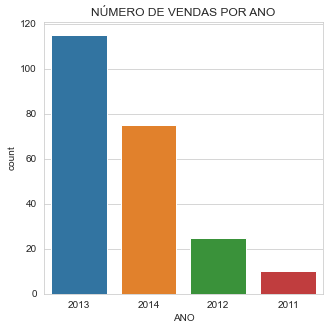

In [40]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 5 EM UM GRAFICO

plt.figure(figsize=(5, 5))
sns.countplot(x="ANO", data=dfVendas_Clean, order = dfVendas_Clean['ANO'].value_counts().index)
plt.title('NÚMERO DE VENDAS POR ANO')
#plt.xticks(rotation=90)

(array([0, 1, 2, 3]),
 [Text(0, 0, '2013'),
  Text(1, 0, '2014'),
  Text(2, 0, '2012'),
  Text(3, 0, '2011')])

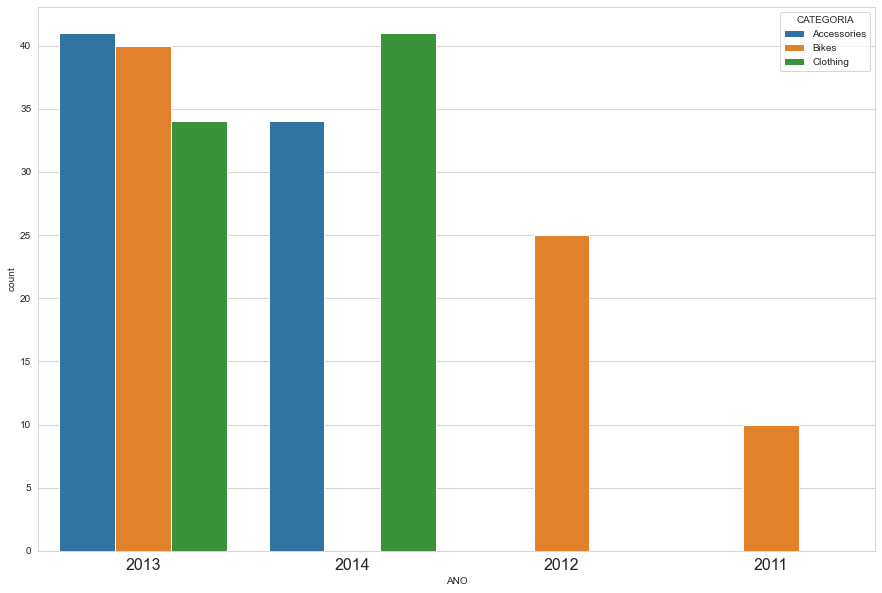

In [41]:
# 6. Quais são os top 5 produto tem o maior numero de vendas por categoria ?

plt.figure(figsize=(15, 10))
sns.countplot(x="ANO", data=dfVendas_Clean, hue='CATEGORIA', order=dfVendas_Clean.ANO.value_counts().iloc[:5].index)
plt.xticks(size=16)

# R:
   # 2011, não há como medir, registros de uma única categoria
   # 2012, não há como medir, registros de uma única categoria
   # 2013, Accessories possui o maior numero de vendas
   # 2014, Clothing possui o maior numero de vendas

In [42]:
# 7.Qual categoria possui o maior numero de vendas (quantidade) no ultimo ano ?

ano_max = dfVendas_Clean.groupby(['ANO', 'CATEGORIA']).size().reset_index(name='count')
ano_max_idx = ano_max.groupby(['ANO'])['count'].transform(max) == ano_max['count']
ano_max_cat = ano_max[ano_max_idx].reset_index(drop=True)
ano_max_cat = ano_max_cat.drop_duplicates(subset=["ANO", "count"], keep='last').reset_index(drop=True)
# ano_max_cat

In [43]:
categoria = ano_max_cat['CATEGORIA'].values
# categoria[0]

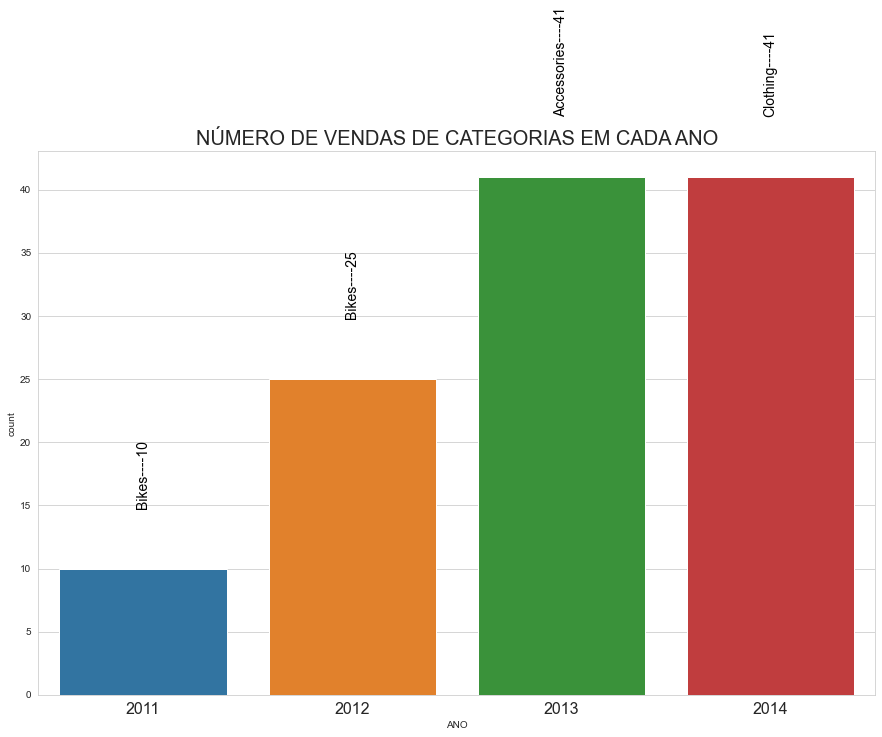

In [44]:
#MOSTRANDO A RESPOSTA DA PERGUNTA 7 EM UM GRAFICO

plt.figure(figsize=(15, 10))
g = sns.barplot(x='ANO', y='count', data=ano_max_cat)
index = 0
for value in ano_max_cat['count'].values:
#     print(asd)
    g.text(index, value + 5, str(categoria[index] + '----' +str(value)), color='#000', size=14, rotation= 90, ha="center")
    index += 1

plt.title('NÚMERO DE VENDAS DE CATEGORIAS EM CADA ANO', fontsize=20)
plt.xticks(size=16)
plt.show()

# R -> 2011, Bikes; 2012, Bikes; 2013, Accessories e em 2014, Clothing

In [45]:
# 8.Qual categoria possui a maior venda em cada ano ?

ano_venda = dfVendas_Clean.groupby(by=['ANO', 'CATEGORIA'])['VENDAS'].sum().reset_index()
ano_venda_df = ano_venda.groupby(by=['ANO'])['VENDAS'].transform(max) == ano_venda['VENDAS']
ano_venda_max = ano_venda[ano_venda_df].reset_index(drop=True)
# ano_venda_max

In [46]:
cat = ano_venda_max['CATEGORIA']

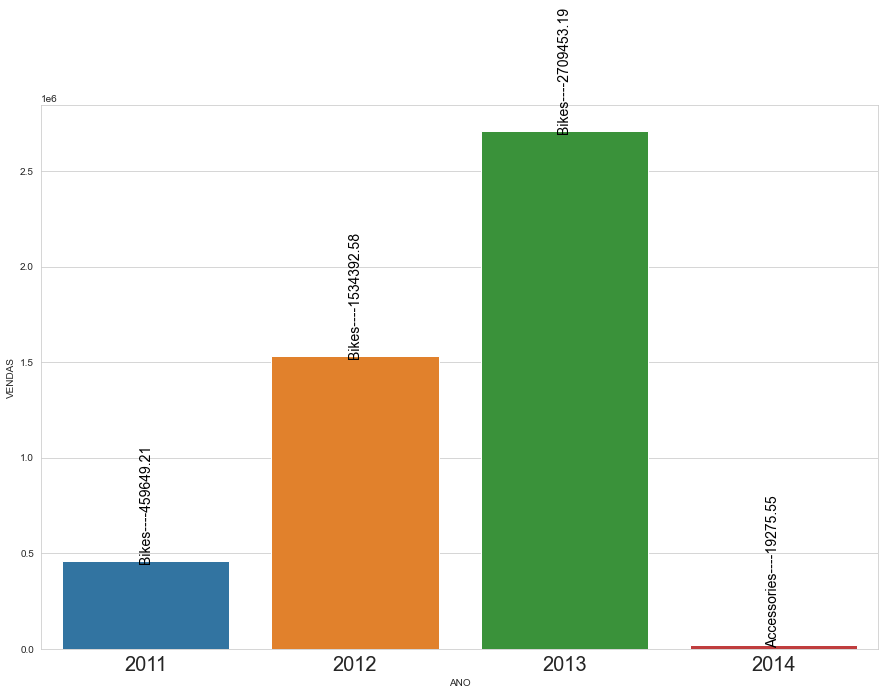

In [47]:
# MOSTRANDO A RESPOSTA DA PERGUNTA 8 EM UM GRAFICO

plt.figure(figsize=(15, 10))
g = sns.barplot(x='ANO', y='VENDAS', data=ano_venda_max)
index = 0
for value in ano_venda_max['VENDAS']:
    g.text(index, value + 2 , str(cat[index] + '----' +str(round(value, 2))), color='#000', size=14, rotation= 90, ha="center")
    index += 1

plt.xticks(size=20)    
plt.show()

# OUTRAS MEDIDAS

In [48]:
# 9. Qual a representividade de vendas (média) de cada categoria ?

dfVendas_partCat = dfVendas_Clean.groupby('CATEGORIA', as_index=False)['VENDAS'].mean()

dfVendas_partCat

,CATEGORIA,VENDAS
0,Accessories,1314.372800
1,Bikes,62713.266405
2,Clothing,608.722667


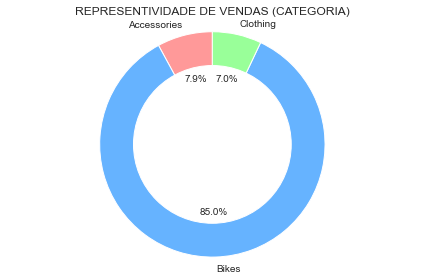

In [49]:
# Pie chart
labels = dfVendas_partCat['CATEGORIA']
sizes = dfVendas_partCat['VENDAS'] + 5000 # valor de 5000 é valor constante somente pra não deixar os menores valores sobrepostos no grafico

#cores
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

#desenhando o circulo
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('REPRESENTIVIDADE DE VENDAS (CATEGORIA)')
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# R -> Bikes, 85%; Acessories, 7.8% e Clothing 7%

In [50]:
# Criando uma rank de vendas

#data["Rank"] = data["Name"].rank()

dfVendas_CleanAccessories['RANK_VENDAS'] = dfVendas_CleanAccessories['VENDAS'].rank(ascending=False)
dfVendas_AccessoriesRank = dfVendas_CleanAccessories.sort_values("VENDAS", inplace = False, ascending=False)
dfVendas_AccessoriesRank

,ANO,PRODUTO,CATEGORIA,PAIS,REGIAO,VENDAS,RANK_VENDAS
262,2013,Fender Set - Mountain,Accessories,Germany,Europe,3406.90,1.0
200,2013,Touring Tire,Accessories,Germany,Europe,3304.86,2.0
624,2013,All-Purpose Bike Stand,Accessories,Germany,Europe,3180.00,3.0
242,2013,LL Road Tire,Accessories,Germany,Europe,3094.56,4.0
378,2013,Hitch Rack - 4-Bike,Accessories,France,Europe,2880.00,5.0
...,...,...,...,...,...,...,...
612,2014,Mountain Bottle Cage,Accessories,United States,North America,339.66,71.0
742,2014,Hydration Pack - 70 oz.,Accessories,Australia,Pacific,329.94,72.0
316,2014,LL Mountain Tire,Accessories,Canada,North America,324.87,73.0
69,2014,All-Purpose Bike Stand,Accessories,Canada,North America,318.00,74.0


In [51]:
dfVendas_CleanBikes['RANK_VENDAS'] = dfVendas_CleanBikes['VENDAS'].rank(ascending=False)
dfVendas_BikessRank = dfVendas_CleanBikes.sort_values("VENDAS", inplace = False, ascending=False)

dfVendas_CleanClothing['RANK_VENDAS'] = dfVendas_CleanClothing['VENDAS'].rank(ascending=False)
dfVendas_ClothingRank = dfVendas_CleanClothing.sort_values("VENDAS", inplace = False, ascending=False)

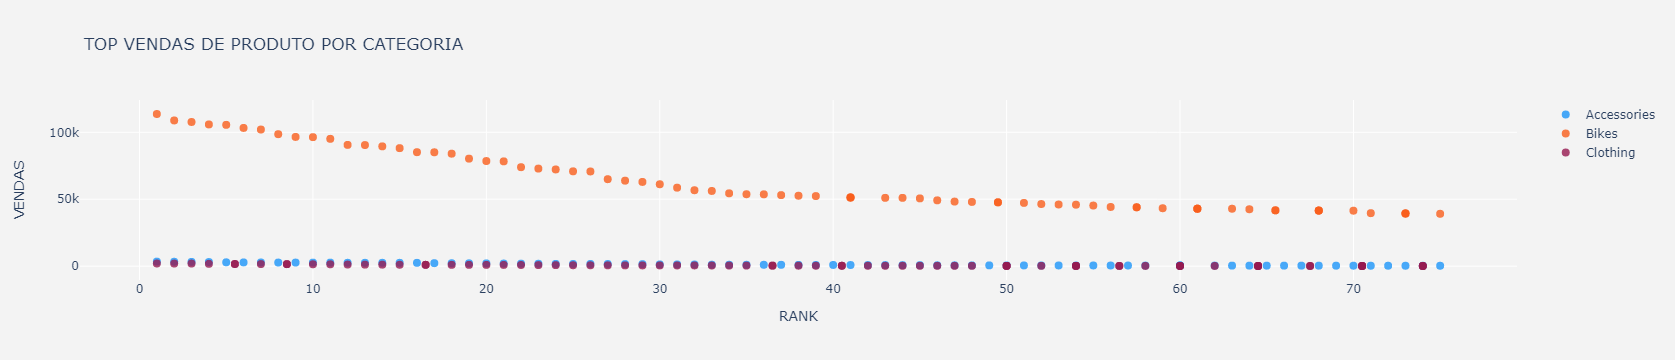

In [62]:
linha1 = go.Scatter(
                    x = dfVendas_AccessoriesRank.RANK_VENDAS,
                    y = dfVendas_AccessoriesRank.VENDAS,
                    mode = "markers",
                    name = "Accessories",
                    marker = dict(color = 'rgba(28, 149, 249, 0.8)',size=8),
                    text= [f'PRODUTO: {string1}<br>PAIS: {string2}'
                           for string1, string2, in zip(dfVendas_AccessoriesRank['PRODUTO'], dfVendas_AccessoriesRank['PAIS'])])

linha2 = go.Scatter(
                    x = dfVendas_CleanBikes.RANK_VENDAS,
                    y = dfVendas_CleanBikes.VENDAS,
                    mode = "markers",
                    name = "Bikes",
                    marker = dict(color = 'rgba(249, 94, 28, 0.8)',size=8),
                    text= [f'PRODUTO: {string1}<br>PAIS: {string2}'
                           for string1, string2, in zip(dfVendas_CleanBikes['PRODUTO'], dfVendas_CleanBikes['PAIS'])])

linha3 = go.Scatter(
                    x = dfVendas_ClothingRank.RANK_VENDAS,
                    y = dfVendas_ClothingRank.VENDAS,
                    mode = "markers",
                    name = "Clothing",
                    marker = dict(color = 'rgba(150, 26, 80, 0.8)',size=8),
                    text= [f'PRODUTO: {string1}<br>PAIS: {string2}'
                           for string1, string2, in zip(dfVendas_ClothingRank['PRODUTO'], dfVendas_ClothingRank['PAIS'])])
                    

data = [linha1, linha2, linha3]
    
layout = dict(title = 'TOP VENDAS DE PRODUTO POR CATEGORIA',
              xaxis= dict(title= 'RANK',ticklen= 5,zeroline= False,zerolinewidth=1,gridcolor="white"),
              yaxis= dict(title= 'VENDAS',ticklen= 5,zeroline= False,zerolinewidth=1,gridcolor="white",),
              paper_bgcolor='rgb(243, 243, 243)',
              plot_bgcolor='rgb(243, 243, 243)' )
    
fig = go.Figure(dict(data = data, layout = layout))
iplot(fig)

In [53]:
dfVendasCopy = dfVendas_Clean
dfVendasCopy['VENDAS_CONVERTIDO'] = dfVendasCopy['VENDAS'] /1000 #valor para gerar as cores

dfVendasCopy['RANK'] = dfVendasCopy['VENDAS'].rank(ascending=False, method='max')

dfVendasCopy

,ANO,PRODUTO,CATEGORIA,PAIS,REGIAO,VENDAS,VENDAS_CONVERTIDO,RANK
262,2013,Fender Set - Mountain,Accessories,Germany,Europe,3406.90,3.40690,76.0
200,2013,Touring Tire,Accessories,Germany,Europe,3304.86,3.30486,77.0
624,2013,All-Purpose Bike Stand,Accessories,Germany,Europe,3180.00,3.18000,78.0
242,2013,LL Road Tire,Accessories,Germany,Europe,3094.56,3.09456,79.0
378,2013,Hitch Rack - 4-Bike,Accessories,France,Europe,2880.00,2.88000,80.0
...,...,...,...,...,...,...,...,...
376,2014,"Women's Mountain Shorts, S",Clothing,Canada,North America,139.98,0.13998,222.0
419,2013,"Women's Mountain Shorts, M",Clothing,Germany,Europe,139.98,0.13998,222.0
101,2014,"Classic Vest, L",Clothing,United States,North America,127.00,0.12700,225.0
164,2014,"Classic Vest, M",Clothing,United Kingdom,Europe,127.00,0.12700,225.0


In [54]:
markVendas = dfVendasCopy['VENDAS'] > 50000 # pegar vendas superiores a 50 k

dfVendas_50k = dfVendasCopy[markVendas]

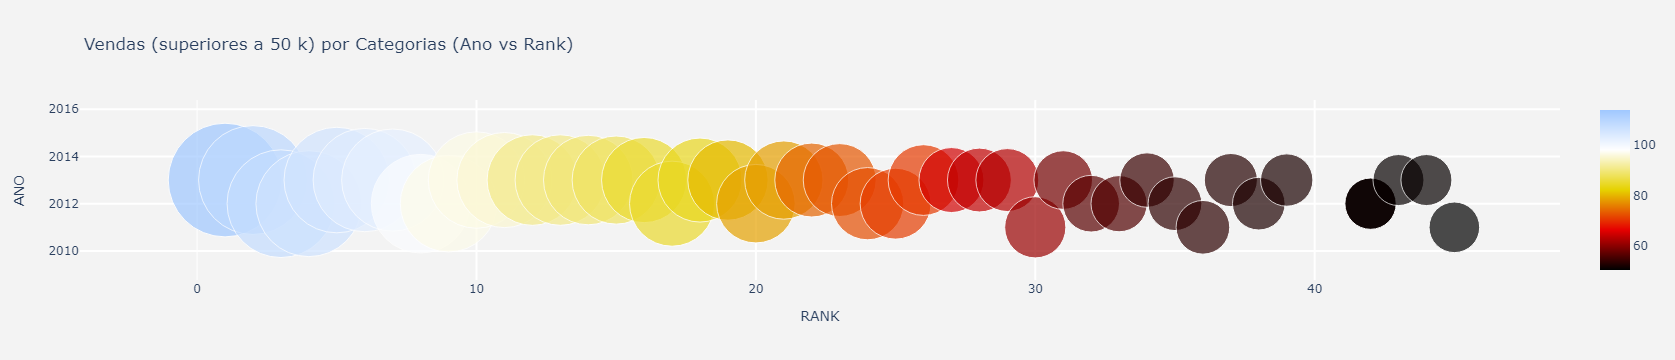

In [73]:
fig2={
    "data" : [
    {
        'x': dfVendas_50k.RANK,
        'y': dfVendas_50k.ANO,
        'mode': 'markers',
        'marker': {
            "color":dfVendas_50k.VENDAS_CONVERTIDO,
            'size': dfVendas_50k.VENDAS_CONVERTIDO,
            'showscale': True,
            "colorscale":'Blackbody'
        },
        "text" :  "Produto: "+ dfVendas_50k.PRODUTO +","+" Categoria: " + dfVendas_50k.CATEGORIA
        
    },
],
"layout":
    {
    "title":"Vendas (superiores a 50 k) por Categorias (Ano vs Rank)",
    "xaxis":{
        "title":"RANK",
        "gridcolor":'rgb(255, 255, 255)',
        "zerolinewidth":1,
        "ticklen":5,
        "gridwidth":2,
    },
    "yaxis":{
        "title":'ANO',
        "gridcolor":'rgb(255, 255, 255)',
        "zerolinewidth":1,
        "ticklen":5,
        "gridwidth":2,
    },
    
    "paper_bgcolor":'rgb(243, 243, 243)',
    "plot_bgcolor":'rgb(243, 243, 243)'
    }}

iplot(fig2)

### SALVANDO TODOS OS GRAFICOS EM IMG

In [81]:
#  diretório de saída para armazenar nossas imagens

import os

if not os.path.exists("Graficos"):
    os.mkdir("Graficos")

In [82]:
fig.write_html("Graficos/graf_VendasRank.html")

In [83]:
import plotly

In [84]:
plotly.offline.plot(fig2, filename='Graficos/graf_Top50Rank.html')

'Graficos/graf_Top50Rank.html'